<a href="https://colab.research.google.com/github/unmtransinfo/reprotox/blob/main/reprotox_thalidomide_use_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="right" src="https://www.nih-cfde.org/wp-content/uploads/2020/11/CFDE_logo-color-web.png" width="200">

# ReproTox chemo-centric analytics and scientific use cases

This notebook code first searches the Neo4J database to get all drugs associated with birth defects, and for each drug, it also counts the number of associated birth defects.
Scientific use cases are based on the known teratogen thalidomide, which is found in the database and associated with birth defects as expected. 
A similarity search using thalidomide other drugs associated with birth defects.
The search returns the chemical structure of all those drugs, Tanimoto similarity with thalidomide, and the number of birth defects associated with the drug.

In [12]:
!pip install rdkit-pypi
import sys,os,json,base64,io,requests,urllib.request
import pandas as pd
from IPython.core.display import display, HTML
from rdkit import Chem,DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
!pip install py2neo
import py2neo
import numpy as np
import xgboost as xgb
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from collections import Counter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Neo4J connection 
**Credentials to connect to Neo4J KG database and create a graph object**

In [13]:
dbhost="18.237.14.238"
dbport=7688
dbscheme="bolt"
dbusr="neo4j"
dbpw="M6E-eDY2_oUWVcAhE-ehJwJN"
db = py2neo.GraphService(host=dbhost, port=dbport, scheme=dbscheme, secure=False, user=dbusr, password=dbpw)
grph = db.default_graph

## Get smiles for all drugs
**KG does not have "smiles" for all drugs. So, use smiles downloaded from the PubChem website. "smiles.csv" contains PubChem "CID" and "smiles". The following code creates a dictionary to store CID as keys and smiles as values.**

In [14]:
# use pubChecm CID as keys and smiles as values.
from urllib.request import urlopen

with urlopen('https://raw.githubusercontent.com/unmtransinfo/reprotox/main/smiles.csv') as response:
  id_smiles_dict = dict(line.decode("utf-8").strip().split(',') for line in response)
  #print(id_smiles_dict)

## Select all drugs from the KG

**The following code selects all drugs from the Neo4J KG database. If smiles is missing for a drug, populate it using the dictionary (id_smiles_dict)created above.**

In [15]:
# select all drugs
cql = "MATCH (d:Drug) RETURN DISTINCT d.id, d.label, d.smiles, d.drugcentral_id, d.lsm;"
results = grph.run(cql)
drugs = results.to_data_frame()

# put smiles if missing
for i, v in enumerate(drugs['d.smiles']):
  if v is None or 'null' in v:
    try:
      drugs.loc[i, 'd.smiles'] = id_smiles_dict[drugs['d.id'][i]]
    except:
      drugs.loc[i, 'd.smiles'] = 0

# drop all drugs without smiles
print("Before dropping drugs.shape", drugs.shape)
drugs = drugs.loc[drugs['d.smiles'] != 0]
print("After dropping drugs.shape", drugs.shape)
drugs.head(5)


Before dropping drugs.shape (4564, 5)
After dropping drugs.shape (4454, 5)


,d.id,d.label,d.smiles,d.drugcentral_id,d.lsm
0,43815,paroxetine,FC1=CC=C(C=C1)[C@@H]1CCNC[C@H]1COC1=CC2=C(OCO2...,2068,None
1,3878,lamotrigine,NC1=NN=C(C(N)=N1)C1=C(Cl)C(Cl)=CC=C1,1540,LSM-4104
2,1775,phenytoin,O=C1NC(=O)C(N1)(C1=CC=CC=C1)C1=CC=CC=C1,2152,LSM-5663
4,5281078,mycophenolate-mofetil,COC1=C(C)C2=C(C(=O)OC2)C(O)=C1C\C=C(/C)CCC(=O)...,1859,LSM-4071
5,9782,betamethasone,C[C@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@...,348,LSM-1248


## Use RDKit to get fingerprints of drugs
**The following code gets the fingerprints for all drugs**

In [16]:
drugs['mol'] = [Chem.MolFromSmiles(smi) for smi in drugs['d.smiles']]
drugs['fp'] = [Chem.RDKFingerprint(mol) for mol in drugs['mol']]
print(drugs.shape)
drugs.head(5)

(4454, 7)


,d.id,d.label,d.smiles,d.drugcentral_id,d.lsm,mol,fp
0,43815,paroxetine,FC1=CC=C(C=C1)[C@@H]1CCNC[C@H]1COC1=CC2=C(OCO2...,2068,None,<rdkit.Chem.rdchem.Mol object at 0x7fef21714030>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,3878,lamotrigine,NC1=NN=C(C(N)=N1)C1=C(Cl)C(Cl)=CC=C1,1540,LSM-4104,<rdkit.Chem.rdchem.Mol object at 0x7fef21714bc0>,"[0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, ..."
2,1775,phenytoin,O=C1NC(=O)C(N1)(C1=CC=CC=C1)C1=CC=CC=C1,2152,LSM-5663,<rdkit.Chem.rdchem.Mol object at 0x7fef217140d0>,"[0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, ..."
4,5281078,mycophenolate-mofetil,COC1=C(C)C2=C(C(=O)OC2)C(O)=C1C\C=C(/C)CCC(=O)...,1859,LSM-4071,<rdkit.Chem.rdchem.Mol object at 0x7fef217149e0>,"[1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, ..."
5,9782,betamethasone,C[C@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@...,348,LSM-1248,<rdkit.Chem.rdchem.Mol object at 0x7fef21714b20>,"[1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."


# Scientific use case: Known teratogen Thalidomide and other drugs associated by chemical similarity

Thalidomide is a well documented teratogen as described by [Vargesson, 2015](https://pubmed.ncbi.nlm.nih.gov/26043938/). Given the similarity principle, that similar chemicals are likely to exhibit similar biological function, we explore the Neo4j KG for similar chemicals to illuminate related chemical biology.

In [17]:
drug_thalidomide = drugs[(drugs['d.label']=='thalidomide')]
drug_thalidomide.transpose()

,97
d.id,5426
d.label,thalidomide
d.smiles,O=C1N(C2CCC(=O)NC2=O)C(=O)C2=C1C=CC=C2
d.drugcentral_id,2616
d.lsm,LSM-1914
mol,<rdkit.Chem.rdchem.Mol object at 0x7fef21624800>
fp,"[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, ..."


Birth defects associated with drug:

In [18]:
cql = """MATCH (d:Drug)--(bd:BirthDefect) WHERE d.label = "thalidomide" RETURN d.label,d.drugcentral_id,bd.id,bd.label,bd.uri"""
results = grph.run(cql)
results.to_data_frame()

,d.label,d.drugcentral_id,bd.id,bd.label,bd.uri
0,thalidomide,2616,HP:0002176,Spinal cord compression,https://hpo.jax.org/app/browse/term/HP:0002176
1,thalidomide,2616,Orphanet_3378,Orphanet_3378,None


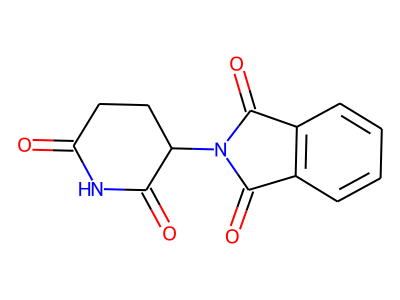

In [19]:
drug_smiles = drug_thalidomide['d.smiles'].values[0]
Draw.MolToImage(Chem.MolFromSmiles(drug_smiles), size=(400, 300)) 

## Compute Tanimoto similarity between thalidomide and other drugs in the KG.

In [20]:
thalidomide_fp = drug_thalidomide['fp'].values[0]
drugs['similarity'] = [DataStructs.TanimotoSimilarity(thalidomide_fp, v) for v in drugs['fp']] 
drugs = drugs.sort_values(by=['similarity'], ascending=False)
drugs = drugs.drop(columns=['mol', 'fp'])
drugs.head(5)


,d.id,d.label,d.smiles,d.drugcentral_id,d.lsm,similarity
97,5426,thalidomide,O=C1N(C2CCC(=O)NC2=O)C(=O)C2=C1C=CC=C2,2616,LSM-1914,1.000000
504,134780,pomalidomide,C1CC(=O)NC(=O)C1N2C(=O)C3=C(C2=O)C(=CC=C3)N,None,None,0.818083
210,40461270,lenalidomide,C1CC(=O)NC(=O)[C@@H]1N2CC3=C(C2=O)C=CC=C3N,None,LSM-6187,0.809255
4054,4431,NAN-190,COC1=CC=CC=C1N2CCN(CC2)CCCCN3C(=O)C4=CC=CC=C4C3=O,None,LSM-3548,0.571128
3819,65937,dexloxiglumide,CCCCCN(CCCOC)C(=O)[C@@H](CCC(=O)O)NC(=O)C1=CC(...,None,None,0.542888


Print chemical structure, id, label, and similarity values for drgus.

,img,d.id,d.label,similarity
97,,5426,thalidomide,1.00
504,,134780,pomalidomide,0.82
210,,40461270,lenalidomide,0.81
4054,,4431,NAN-190,0.57
3819,,65937,dexloxiglumide,0.54
2517,,702558,RG-108,0.51
4418,,183470,U-54494A,0.50
1123,,4462449,CAY-10578,0.50
543,,6337614,palonosetron,0.50
3434,,3917094,ST-4070043,0.48

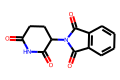
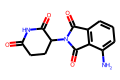
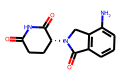
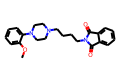
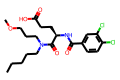
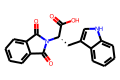
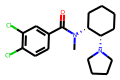
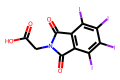
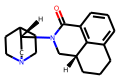
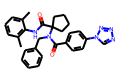

In [21]:
# print chemical structure
imglist = []
for i,smi in enumerate(drugs['d.smiles']):
  mol = Chem.MolFromSmiles(smi)
  img = Draw.MolToImage(mol, size=(120, 80))
  img_buffer = io.BytesIO()
  img.save(img_buffer, format="PNG")
  imgStr = base64.b64encode(img_buffer.getvalue()).decode('utf8')
  imglist.append(f"""<img src="data:image/png;base64,{imgStr}">""")
drugs['img'] = imglist
drugs1 = drugs.head(10)
display(HTML(drugs1[["img", "d.id", "d.label", "similarity"]].round(2).to_html(escape=False)))




## Create data using fingerprints of drugs to run ML
- drugs associated with birth defect as class 1
- drugs not associated with birth defect as class 0
- run XGBoost with 5-fold CV and return predicted probabilities

**Select all drugs associated with birth defects (class 1) from KG. If "smiles" is missing, use smiles from the PubChem file.**

In [22]:
# select only birth defect associated drugs
cql = "MATCH (d:Drug)-[]-(bd:BirthDefect) RETURN DISTINCT d.id, d.label, d.smiles;"
results = grph.run(cql)
drugs = results.to_data_frame()
# print(drugs)

# put smiles if missing
for i, v in enumerate(drugs['d.smiles']):
  if v is None or 'null' in v:
    try:
      drugs.loc[i, 'd.smiles'] = id_smiles_dict[drugs['id'][i]]
    except:
      drugs.loc[i, 'd.smiles'] = 0

# drop all drugs without smiles
print("Before dropping drugs.shape", drugs.shape)
bd_drugs = drugs.loc[drugs['d.smiles'] != 0]
print("After dropping drugs.shape", bd_drugs.shape)

bd_drugs_smiles = bd_drugs['d.smiles'].to_numpy()
bd_drugs = pd.DataFrame(bd_drugs)
bd_drugs.head(5)

Before dropping drugs.shape (414, 3)
After dropping drugs.shape (119, 3)


,d.id,d.label,d.smiles
0,446155,fluvastatin,CC(C)N1C(\C=C\[C@H](O)C[C@H](O)CC(O)=O)=C(C2=C...
2,38853,methyldopa,C[C@](N)(CC1=CC(O)=C(O)C=C1)C(O)=O
3,2771,citalopram,CN(C)CCCC1(OCC2=C1C=CC(=C2)C#N)C1=CC=C(F)C=C1
4,14806,zinc oxide,O=[Zn]
5,35370,zidovudine,CC1=CN([C@H]2C[C@H](N=[N+]=[N-])[C@@H](CO)O2)C...


**Select all drugs from KG. If "smiles" is missing, use smiles from the PubChem file.**

In [23]:

# select all drugs
cql = "MATCH (d:Drug) RETURN DISTINCT d.id, d.label, d.smiles;"
results = grph.run(cql)
drugs = results.to_data_frame()

# put smiles if missing
for i, v in enumerate(drugs['d.smiles']):
  if v is None or 'null' in v:
    try:
      drugs.loc[i, 'd.smiles'] = id_smiles_dict[drugs['d.id'][i]]
    except:
      drugs.loc[i, 'd.smiles'] = 0

# drop all drugs without smiles
print("Before dropping drugs.shape", drugs.shape)
all_drugs = drugs.loc[drugs['d.smiles'] != 0]
print("After dropping drugs.shape", all_drugs.shape)
all_drugs = pd.DataFrame(all_drugs)
all_drugs.head(5)

Before dropping drugs.shape (4564, 3)
After dropping drugs.shape (4454, 3)


,d.id,d.label,d.smiles
0,43815,paroxetine,FC1=CC=C(C=C1)[C@@H]1CCNC[C@H]1COC1=CC2=C(OCO2...
1,3878,lamotrigine,NC1=NN=C(C(N)=N1)C1=C(Cl)C(Cl)=CC=C1
2,1775,phenytoin,O=C1NC(=O)C(N1)(C1=CC=CC=C1)C1=CC=CC=C1
4,5281078,mycophenolate-mofetil,COC1=C(C)C2=C(C(=O)OC2)C(O)=C1C\C=C(/C)CCC(=O)...
5,9782,betamethasone,C[C@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@...


**Find all drugs that are not associated with birth defects (class 0).**

In [24]:
# from all drugs, select drugs that are not associated with birth defect
non_bd_drugs = all_drugs[~all_drugs['d.smiles'].isin(bd_drugs_smiles)]
non_bd_drugs = pd.DataFrame(non_bd_drugs)
print(all_drugs.shape, len(bd_drugs_smiles), len(non_bd_drugs))
non_bd_drugs.head(5)

(4454, 3) 119 4335


,d.id,d.label,d.smiles
26,118984445,insulin aspart,CC[C@H](C)[C@H]1C(=O)N[C@H]2CSSC[C@@H](C(=O)N[...
28,24580,manganese sulfate,[O-]S(=O)(=O)[O-].[Mn+2]
40,121494085,sucralfate,C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)O[C@]2([C...
52,772,heparin,CC(=O)NC1C(C(C(OC1O)COS(=O)(=O)O)OC2C(C(C(C(O2...
54,5311498,cyanocobalamin,CC1=CC2=C(C=C1C)N(C=N2)[C@@H]3[C@@H]([C@@H]([C...


**Using RDKit, get the fingerprints for all drugs associated with birth defects**

In [25]:
# get fingerprints for bd drugs
bd_drugs['mol'] = [Chem.MolFromSmiles(smi) for smi in bd_drugs['d.smiles']]
bd_drugs['fp'] = [Chem.RDKFingerprint(mol) for mol in bd_drugs['mol']]
print(bd_drugs.shape)
bd_drugs.head(5)

(119, 5)


,d.id,d.label,d.smiles,mol,fp
0,446155,fluvastatin,CC(C)N1C(\C=C\[C@H](O)C[C@H](O)CC(O)=O)=C(C2=C...,<rdkit.Chem.rdchem.Mol object at 0x7fef214d1df0>,"[1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, ..."
2,38853,methyldopa,C[C@](N)(CC1=CC(O)=C(O)C=C1)C(O)=O,<rdkit.Chem.rdchem.Mol object at 0x7fef214d1300>,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ..."
3,2771,citalopram,CN(C)CCCC1(OCC2=C1C=CC(=C2)C#N)C1=CC=C(F)C=C1,<rdkit.Chem.rdchem.Mol object at 0x7fef214d1b20>,"[0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, ..."
4,14806,zinc oxide,O=[Zn],<rdkit.Chem.rdchem.Mol object at 0x7fef214d1da0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,35370,zidovudine,CC1=CN([C@H]2C[C@H](N=[N+]=[N-])[C@@H](CO)O2)C...,<rdkit.Chem.rdchem.Mol object at 0x7fef214d1530>,"[1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, ..."


**Using RDKit, get the fingerprints for all drugs notassociated with birth defects**

In [26]:
# get fingerprints for non_bd drugs
non_bd_drugs['mol'] = [Chem.MolFromSmiles(smi) for smi in non_bd_drugs['d.smiles']]
non_bd_drugs['fp'] = [Chem.RDKFingerprint(mol) for mol in non_bd_drugs['mol']]
print(non_bd_drugs.shape)
non_bd_drugs.head(5)

(4335, 5)


,d.id,d.label,d.smiles,mol,fp
26,118984445,insulin aspart,CC[C@H](C)[C@H]1C(=O)N[C@H]2CSSC[C@@H](C(=O)N[...,<rdkit.Chem.rdchem.Mol object at 0x7fef214e5850>,"[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, ..."
28,24580,manganese sulfate,[O-]S(=O)(=O)[O-].[Mn+2],<rdkit.Chem.rdchem.Mol object at 0x7fef214e5800>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
40,121494085,sucralfate,C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)O[C@]2([C...,<rdkit.Chem.rdchem.Mol object at 0x7fef214e56c0>,"[1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, ..."
52,772,heparin,CC(=O)NC1C(C(C(OC1O)COS(=O)(=O)O)OC2C(C(C(C(O2...,<rdkit.Chem.rdchem.Mol object at 0x7fef214e58f0>,"[1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, ..."
54,5311498,cyanocobalamin,CC1=CC2=C(C=C1C)N(C=N2)[C@@H]3[C@@H]([C@@H]([C...,<rdkit.Chem.rdchem.Mol object at 0x7fef214e58a0>,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ..."


**Generate a feature matrix using the fingerprints of all drugs not associated with birth defects (class 0)**

In [27]:
# generate feature vectors for non_bd drugs
non_bd_fps = non_bd_drugs['fp'].values
non_bd_drug_ids = non_bd_drugs['d.id'].values
non_bd_drug_labels = non_bd_drugs['d.label'].values


# convert fp to feature vector
non_bd_X = np.asarray([list(v.ToBitString()) for v in non_bd_fps], dtype=np.int8)
print(non_bd_X.shape)
non_bd_X[:5]


(4335, 2048)


array([[1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int8)

**Generate a feature matrix using the fingerprints of all drugs associated with birth defects (class 1)**

In [28]:
# generate feature vectors for bd drugs
bd_fps = bd_drugs['fp'].values
bd_drug_ids = bd_drugs['d.id'].values
bd_drug_labels = bd_drugs['d.label'].values

# convert fp to feature vector
bd_X = np.asarray([list(v.ToBitString()) for v in bd_fps], dtype=np.int8)
print(bd_X.shape)
bd_X[:5]

(119, 2048)


array([[1, 1, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 1, 1]], dtype=int8)

**Combine class 0 and class 1 feature matrix.**

In [29]:
# generate features and labels
X = np.concatenate([bd_X, non_bd_X], axis=0)
print(X.shape)
y = np.concatenate([[1]*bd_X.shape[0], [0]*non_bd_X.shape[0]], axis=0)
print(y, len(y))

# generate list of labels and ids
all_labels = np.concatenate([bd_drug_labels, non_bd_drug_labels], axis=0)
all_ids = np.concatenate([bd_drug_ids, non_bd_drug_ids], axis=0)
print(len(all_labels), len(all_ids))

(4454, 2048)
[1 1 1 ... 0 0 0] 4454
4454 4454


## Run ML on the fingerprints data of drugs
 - return predicted probabilities
 - compute AUC and APS
 - save classification results

In [30]:
# file to save classification results
fo = open("classification_results.tsv", "w")
hdr = "drug_id" + "\t" + "drug_label" + "\t" + "y_true" + "\t" + "prediction" + "\t" + "iteration" + "\n"
fo.write(hdr)

# XGBoost parameters
tot = Counter(y)
r = tot[0]/tot[1]
print("ratio 0/1: ", r)

xgb_params = {
    'n_jobs': 16,
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'scale_pos_weight': r,
    'random_state': 1001
}

# Run XGBoost with 5-fold CV for n iterations
n_iters = 10
y_true = {}
y_preds = {}
for itr in range(n_iters):
  print("\nRun ML for iteration {0}".format(itr))
  X, y, all_ids, all_labels = shuffle(X, y, all_ids, all_labels, random_state=1001+itr)

  clf = xgb.XGBClassifier(**xgb_params)
  preds = cross_val_predict(clf, X, y, cv=5, method="predict_proba")
  p1 = preds[:, 1]
  print("AUC-ROC: ", roc_auc_score(y, p1))
  print("Average precision score: ", average_precision_score(y, p1))
  
  # save predictions for AUC plot
  y_true[itr] = y
  y_preds[itr] = p1

  # Save classification results in a file
  for i, id in enumerate(all_ids):
    line = str(id) + "\t" + str(all_labels[i]) + "\t" + str(y[i]) + "\t" + str(p1[i]) + "\t" + str(itr) + "\n"
    fo.write(line)
fo.close()

ratio 0/1:  36.42857142857143

Run ML for iteration 0
AUC-ROC:  0.6616130189099861
Average precision score:  0.06365734152720254

Run ML for iteration 1
AUC-ROC:  0.6786290986983028
Average precision score:  0.06159151756578705

Run ML for iteration 2
AUC-ROC:  0.6855776220522811
Average precision score:  0.06325890363575887

Run ML for iteration 3
AUC-ROC:  0.6593430451765481
Average precision score:  0.0673480348418044

Run ML for iteration 4
AUC-ROC:  0.7105851337074622
Average precision score:  0.07531715336062386

Run ML for iteration 5
AUC-ROC:  0.6742403535808787
Average precision score:  0.06501044373719002

Run ML for iteration 6
AUC-ROC:  0.6816667151289583
Average precision score:  0.06362914491118844

Run ML for iteration 7
AUC-ROC:  0.6856241458521124
Average precision score:  0.062224824555873054

Run ML for iteration 8
AUC-ROC:  0.659715235575199
Average precision score:  0.0809066237003504

Run ML for iteration 9
AUC-ROC:  0.6676727438380197
Average precision score:  0.

**Using predicted probabilies and labels, generate AUC-ROC curve plot for each iteration.**

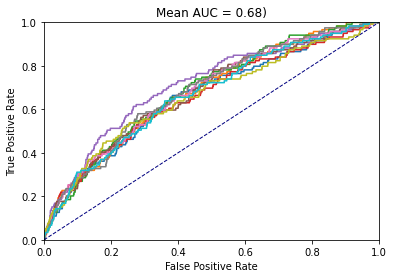

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

# compute sensitivity, specificity for each run
fpr = {}
tpr = {}
roc_auc = []

for i in range(n_iters):
  fpr[i], tpr[i], _ = roc_curve(y_true[i], y_preds[i])
  roc_auc.append(auc(fpr[i], tpr[i]))

# generate plot
plt.figure()
for i in range(n_iters):
  plt.plot(fpr[i], tpr[i])
plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Mean AUC = %0.2f)" % np.mean(roc_auc))
plt.show()

## Find top 25 uncoded drugs using prediction
**The following code selects top 25 drugs from the unlabeled class using their predicted probabilities. It returns chemical structure, id, label, and predicted probability for those drugs.**



,chem_struct,id,label,prediction
0,,6328608,abacavir,0.9357
1,,16490,flumetasone,0.8990
2,,6473866,tacrolimus,0.8877
3,,6741,Methylprednisolone,0.8818
4,,5361202,cefuroxime,0.8801
5,,4583,ofloxacin,0.8547
6,,57495783,deforolimus,0.8506
7,,40469854,flumethasone,0.8504
8,,54197,ceftazidime,0.8434
9,,31307,triamcinolone,0.8428

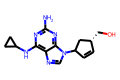
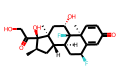
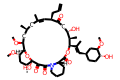
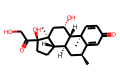
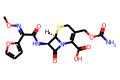
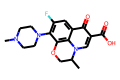
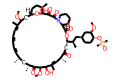
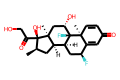
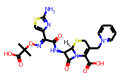
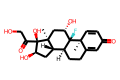
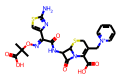
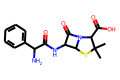
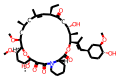
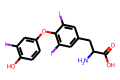
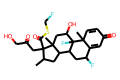
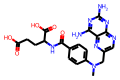
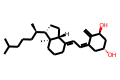
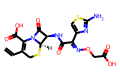
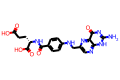
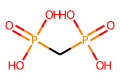
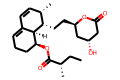
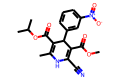
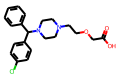
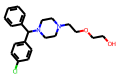
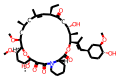

In [32]:
from collections import Counter

drug_prediction_dict = {}   # keys=(drug_id, drug_label), values=prediction
lcount = 0
with open('classification_results.tsv', 'r') as fin:
  for line in fin:
    if lcount == 0:
      lcount+=1
      continue
    vals = line.strip().split("\t")
    drug_id, drug_label, y_true, prediction = vals[0].strip(' '), vals[1].strip(' '), int(vals[2].strip(' ')), float(vals[3].strip(' '))
    
    # select only unlabeled records
    if y_true == 0:
      if (drug_id, drug_label) in drug_prediction_dict:
        drug_prediction_dict[(drug_id, drug_label)] += prediction
      else:
        drug_prediction_dict[(drug_id, drug_label)] = prediction

# take mean value of prediction
for kk, vv in drug_prediction_dict.items():
  drug_prediction_dict[kk] = vv/n_iters

# select top k unlabeled drugs
topK_uncoded_drugs = Counter(drug_prediction_dict).most_common()[:25]
# print(topK_uncoded_drugs)

# print chemical structure, drug_id, drug_label, and prediction
img_list = []
id_list = []
label_list = []
preds_list = []
for (id, label), preds in topK_uncoded_drugs:
  mol = Chem.MolFromSmiles(id_smiles_dict[id])
  img = Draw.MolToImage(mol, size=(120, 80))
  img_buffer = io.BytesIO()
  img.save(img_buffer, format="PNG")
  imgStr = base64.b64encode(img_buffer.getvalue()).decode('utf8')
  img_list.append(f"""<img src="data:image/png;base64,{imgStr}">""")
  id_list.append(id)
  label_list.append(label)
  preds_list.append(preds)

# create a dataframe
uncoded_drugs_df = pd.DataFrame({'chem_struct':img_list, 'id':id_list, 'label':label_list, 'prediction':preds_list})
display(HTML(uncoded_drugs_df[["chem_struct", "id", "label", "prediction"]].round(4).to_html(escape=False)))
